In [1]:
# imports
# general
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy import dot 
from sklearn.metrics import accuracy_score
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
# lime
import lime
import lime.lime_tabular
# advertorch 
from advertorch.attacks import LinfPGDAttack
# cpu / gpu
if torch.cuda.is_available():  
    device = 'cuda:0'
else:  
    device = 'cpu'
print('device: ', device)

device:  cuda:0


In [2]:
# obtain mnist data and process
batch_size = 128

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())
dataset_test = MNIST('.', train=False, download=False,transform=transforms.ToTensor())

train1, train2 = random_split(dataset,[30000,30000])#DataLoader(dataset, batch_size=batch_size)
data_loader_train1 = DataLoader(train1, batch_size=batch_size)
data_loader_train2 = DataLoader(train2, batch_size=batch_size)
data_loader_test = DataLoader(dataset_test, batch_size=1000)

In [3]:
# torch network 
class Net(nn.Module):
    def __init__(self, layers, num_classes=10, net_num=1, dev='cpu'):
        super(Net, self).__init__()
        self.layers = layers
        self.net_num = net_num
        self.path = './models/network'+str(self.net_num)+'_'+str(self.layers)+'.pth'
        self.dev = dev
        # layers
        self.fc_linears = nn.ModuleList()
        for i in range(len(self.layers)-1):
            self.fc_linears.append(nn.Sequential(nn.Linear(in_features=self.layers[i], out_features=self.layers[i+1]),nn.BatchNorm1d(self.layers[i+1]),nn.ReLU()))
        self.f_final = nn.Linear(self.layers[-1],num_classes)
        self.fc_linears.to(dev)
        self.f_final.to(dev)
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        
    def forward(self, x):
        softmax = nn.Softmax(dim=1)
        for l in self.fc_linears:
            x = l(x)
        x = softmax(self.f_final(x))
        return x
    
    def train(self, train_data, loss_fn=nn.CrossEntropyLoss(), n_epochs=50, save=True):
        for epoch in range(n_epochs):
            for data,target in train_data:
                data, target = data.reshape(data.shape[0],28*28).to(self.dev),target.to(self.dev)
                self.optimizer.zero_grad()
                output = self.forward(data)
                loss = loss_fn(output, target)
                loss.backward()
                self.optimizer.step()
            if (epoch+1)%10 == 0:
                print('epoch/epochs: '+str(epoch+1)+'/'+str(n_epochs))
                print('accuracy: ', round((torch.argmax(output,dim=1) == target).sum().item()/len(target)*100.,5), '%')
                print('------------------------------')
        if save:
            torch.save(self.state_dict(), self.path)
            print('saved to '+self.path+'!')
            
    def accuracy(self, test_data):
        correct = 0.
        total = 0.
        for x,y in test_data:
            x,y = x.reshape(x.shape[0],28*28).to(self.dev),y.to(self.dev)
            output = self.forward(x)
            correct += (torch.argmax(output,dim=1) == y).sum().item()
            total += len(y)
        print('model accuracy: ',round((correct/total)*100,5),'%')
        
    def load(self):
        self.load_state_dict(torch.load(self.path))
        print('model loaded from ', self.path, '!')

In [ ]:
# train a bunch of networks
architectures = [[784,500,100],
                [784,900,500,100],
                [784,256,64,32],
                [784,256,128,64,32]]

for i,layers in enumerate(architectures):
    for j in range(4):
        print('------------------------------------------------------------')
        print('ARCHITECTURE ',i,' | MODEL ', j)
        net = Net(layers,net_num=j,dev=device)
        net.train(data_loader_train1, n_epochs=100)
        net.accuracy(data_loader_test)

In [5]:
# load a bunch of networks 
architectures = [[784,500,100],
                [784,900,500,100],
                [784,256,64,32],
                [784,256,128,64,32]]
nets = []
for i,layers in enumerate(architectures):
    for j in range(4):
        net = Net(layers,net_num=j,dev=device)
        net.load()
        nets.append(net)

model loaded from  ./models/network0_[784, 500, 100].pth !
model loaded from  ./models/network1_[784, 500, 100].pth !
model loaded from  ./models/network2_[784, 500, 100].pth !
model loaded from  ./models/network3_[784, 500, 100].pth !
model loaded from  ./models/network0_[784, 900, 500, 100].pth !
model loaded from  ./models/network1_[784, 900, 500, 100].pth !
model loaded from  ./models/network2_[784, 900, 500, 100].pth !
model loaded from  ./models/network3_[784, 900, 500, 100].pth !
model loaded from  ./models/network0_[784, 256, 64, 32].pth !
model loaded from  ./models/network1_[784, 256, 64, 32].pth !
model loaded from  ./models/network2_[784, 256, 64, 32].pth !
model loaded from  ./models/network3_[784, 256, 64, 32].pth !
model loaded from  ./models/network0_[784, 256, 128, 64, 32].pth !
model loaded from  ./models/network1_[784, 256, 128, 64, 32].pth !
model loaded from  ./models/network2_[784, 256, 128, 64, 32].pth !
model loaded from  ./models/network3_[784, 256, 128, 64, 32

In [6]:
for net in nets:
    print(net)

Net(
  (fc_linears): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (f_final): Linear(in_features=100, out_features=10, bias=True)
)
Net(
  (fc_linears): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=500, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (f_final): Linear(in_features=100, out_features=10, b

In [7]:
# set up for lime
x_train = dataset.data.float().to(device)
y_train = dataset.targets.float().to(device)
x_test = dataset_test.data.float().to(device)
y_test = dataset_test.targets.float().to(device)

f_names = np.arange(0,28*28) 
c_names = ['0','1','2','3','4','5','6','7','8','9']

class model_wrap():
    def __init__(self,model,dev='cpu'):
        self.model = model
        self.dev = dev
    
    def predict_proba(self,x):
        try:
            x = torch.from_numpy(x).float().to(self.dev)
        except:
            x = x.float().to(self.dev)
        try:
            output = self.model(x).cpu().detach().numpy()
        except:
            output = self.model(x)
        return output
        
def make_exp_vec(exp):
    """
    Takes a LIME explanation which is a dictionary (i, w(i)) where i is the feature id and w(i) is the weight 
    of the ith feature. With the explanation vector we generate, we can 
    Arg - 
        exp: LIME explanation
    Returns - 
        v: explanation vector where v[i] = w(i)
        y_pred: the prediction of the model
    """
    k = list(exp.keys())[0]
    l = exp[k]
    v = np.zeros(len(l))
    for (i,w) in l:
        v[i] = w
    y_pred = k
    return v,y_pred

def exp_point(point,X,model,f_names,c_names):
    """
    The explanation vector for top label of a point in a certain data set.
    Arg - 
        point: point to explain
        X: data model was trained on
        model: black box
        f_names: names of features
        c_names: names of classes
    Returns - 
        v: explanation vector (see make_exp_vec())
        y_pred: model prediction
    """
    explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=f_names, class_names=c_names, discretize_continuous=False)
    exp = explainer.explain_instance(point, model, num_features=len(point), top_labels=1)
    v,y_pred = make_exp_vec(exp.local_exp)
    return v, y_pred

def cos_sim(v,w):
    """
    Computes the cosine similarity between two vectors.
    Arg - 
        v: numpy array like a vector
        w: numpy array like a vector
    Returns - 
        sim: cosine similarity of the two vectors
    """
    return np.dot(v,w)/(norm(v)*norm(w))

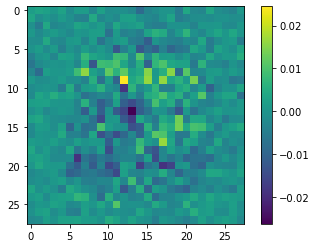

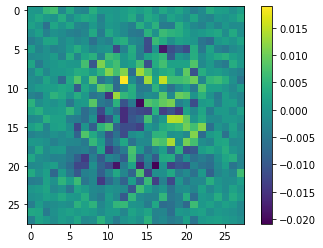

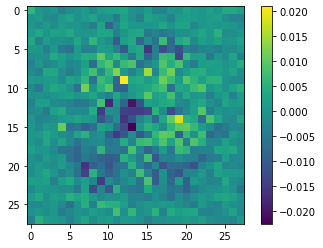

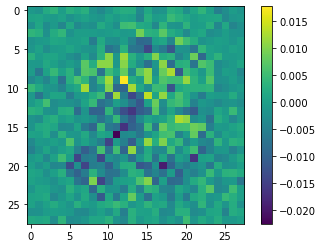

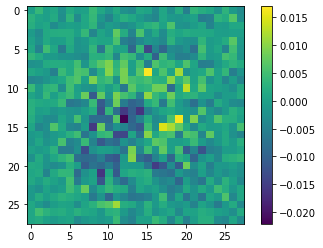

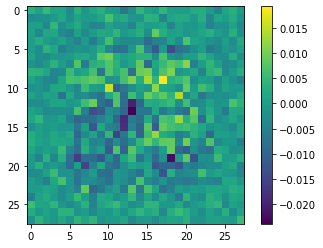

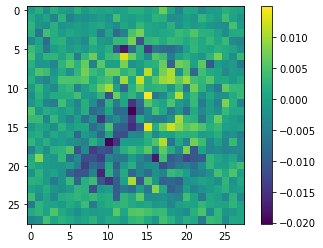

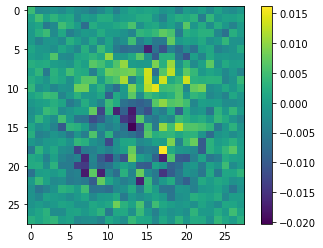

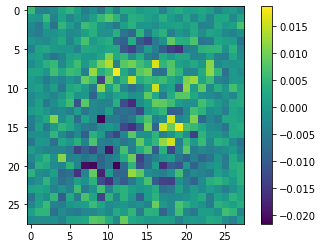

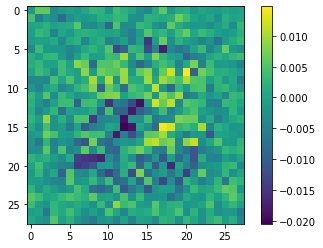

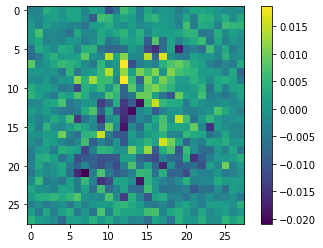

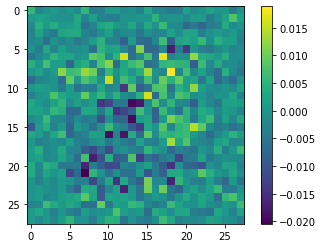

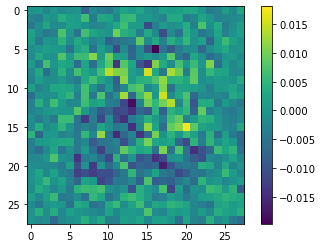

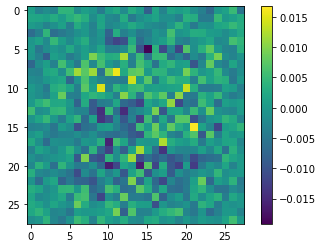

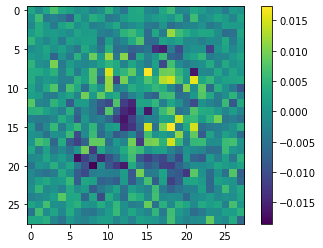

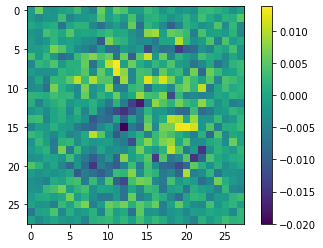

In [8]:
point_exp = x_test[0].reshape(28*28,).cpu().detach().numpy()
tr_data = x_train.reshape(x_train.shape[0],28*28).cpu().detach().numpy()

exp_vecs = []
for i,net in enumerate(nets):
    model = model_wrap(net,dev=device).predict_proba
    v,y_pred = exp_point(point_exp,tr_data,model,f_names,c_names)
    exp_vecs.append(v)
    plt.figure(i)
    plt.imshow(v.reshape(28,28))
    plt.colorbar()
    plt.show()

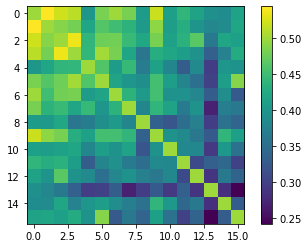

In [9]:
sim_matrix = 0.5*np.ones((16,16))
for i,vec1 in enumerate(exp_vecs):
    for j,vec2 in enumerate(exp_vecs):
        if i == j:
            pass
        else:
            sim_matrix[i,j] = cos_sim(vec1,vec2)
        
plt.figure()
plt.imshow(sim_matrix)
plt.colorbar()
plt.show()

In [10]:
# attack each 

'''
1. generate explanations for each data point (num_models x num_points)
2. generate adv examples for each point (num_models x num_points)
3. plot x = average similarity and y = transferability
'''

point_exps = x_test[500:510].cpu().detach().numpy()
points_attack = x_test[500:510]
points_attack = points_attack.reshape(points_attack.shape[0],28*28)
labels = y_test[500:510]
all_exps = []
adv_examps = []
for i,net in enumerate(nets):
    adversary_LinfPGD = LinfPGDAttack(
        net, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
        nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
        targeted=False)
    pgd_advex = adversary_LinfPGD.perturb(points_attack)
    adv_examps.append(pgd_advex.cpu().detach().numpy())
    model = model_wrap(net,dev=device).predict_proba
    exps = []
    for point in point_exps:
        v,y_pred = exp_point(point_exp,tr_data,model,f_names,c_names)
        exps.append(v)
    all_exps.append(exps)

all_exps = np.array(all_exps)
adv_examps = np.array(adv_examps)

print(all_exps.shape)
print(adv_examps.shape)

(16, 10, 784)
(16, 10, 784)


In [11]:
np.save('./all_explanations.npy',all_exps)
np.save('./all_advexamples.npy',adv_examps)

In [12]:
sim = []
transf = []
amnt_adv = []

for i,(net1,exps1,advs1) in enumerate(zip(nets,all_exps,adv_examps)):
    for j,(net2,exps2,advs2) in enumerate(zip(nets,all_exps,adv_examps)):
        if i > j:
            pass
        else:
            sim.append((1./exps1.shape[0])*norm(exps1-exps2,'fro'))
            out1 = torch.argmax(net1(torch.from_numpy(advs1).to(device)),dim=1)
            amnt_adv.append(1.-accuracy_score(out1.cpu().detach().numpy(),labels.cpu().detach().numpy()))
            tr_net1 = torch.from_numpy(advs1).to(device)[out1 != labels]
            tr_lbl = labels[out1 != labels]
            out2 = torch.argmax(net2(tr_net1),dim=1)
            transf.append(1.-accuracy_score(out2.cpu().detach().numpy(),tr_lbl.cpu().detach().numpy()))

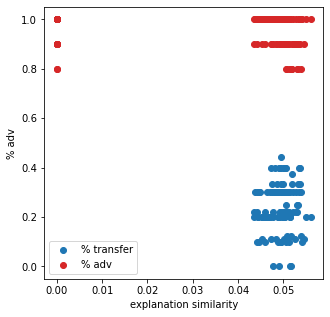

In [13]:
plt.figure(1,[5,5])
plt.scatter(sim,transf,color='tab:blue',label='% transfer')
plt.scatter(sim,amnt_adv,color='tab:red',label='% adv')
plt.xlabel('explanation similarity')
plt.ylabel('% adv')
plt.legend(loc=3)
plt.show()